# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs (thank you Google), however not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not campatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [1]:
# Check to see if we're using a GPU
!nvidia-smi -L
!nvidia-smi

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-2349283b-d8c3-574d-bb05-0097332584c3)
Mon Jul  4 05:30:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P5    17W /  N/A |    968MiB /  6144MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------------

## Get helper functions

In past modules, we've created a bunch of helper functions to do small task required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Download helper functions script
import os
if not os.path.exists("helper_functions.py"):
    !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Dataset to download data

If you want to get an overview of TensorFlow (TFDS) read the guide: https://www.tensorflow.org/datasets/

In [4]:
# Get TensorFlow dataset
import tensorflow_datasets as tfds

In [5]:
# List all available dataset
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target in the list of TFDS datasets?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True, # data gets returned in tuple format (data, label)
    with_info=True
)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape},
    Image datatype: {image.dtype},
    Traget class from Food101 (tensor form): {label},
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Traget class from Food101 (tensor form): 16,
    Class name (str form): cheesecake
    


In [12]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset

(-0.5, 511.5, 511.5, -0.5)

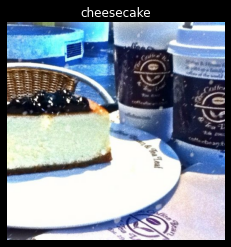

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False)

## Create preprocessing function for our data

Neural Networks perform best, when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data: 
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixes precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (valules between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from `uint8` ->  `float32` and reshapes image to [img_shape, img_shape, colour_channels]
    """
    img = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image befor preprocessing: \n{image[:2]}\nShape: {image.shape}\n{image.dtype}\n")
print(f"Image after preprocessing: \n{preprocessed_img[:2]}\nShape: {preprocessed_img.shape}\n{preprocessed_img.dtype}")

Image befor preprocessing: 
[[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]
Shape: (512, 512, 3)
<dtype: 'uint8'>

Image after preprocessing: 
[[[ 85.  84.  92.]
  [ 86.  85.  93.]
  [ 93.  92. 100.]
  ...
  [120. 196. 245.]
  [120. 198. 246.]
  [121. 199. 247.]]

 [[ 88.  88.  96.]
  [ 82.  82.  90.]
  [ 88.  88.  96.]
  ...
  [116. 192. 244.]
  [118. 195. 249.]
  [119. 196. 248.]]]
Shape: (512, 512, 3)
<dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly recommend going through the following guide: https://www.tensorflow.org/guide/data_performance

In [17]:
# Map preprocessing function to training (ana parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1_000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, Tensorflow, map this preprocessing functing (`preprocess_img`) across our training dataset, then shuffle a number of elementsand then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBaord callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [21]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create model checkpoint callback (to save a model's progress during training)
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

## Setup mixing precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [31]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

In [32]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
